<a href="https://colab.research.google.com/github/CashelF/Dermetric/blob/main/SkinCancerIdentificationModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identify Skin Cancer
### Custom model to identify if a given image of skin contains a disease or not


In [ ]:
# Source Data: https://www.kaggle.com/datasets/andrewmvd/isic-2019

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pickle

In [ ]:
# Pull data from drive

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print("GPU", "available ", tf.config.list_physical_devices())

GPU available  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data Preprocessing
### Transform the given data into a usable state for a model

In [ ]:
training_truth = "/content/drive/MyDrive/ISIC_2019_Training_GroundTruth.csv"
training_mdata = "/content/drive/MyDrive/ISIC_2019_Training_Metadata.csv"

truth_df = pd.read_csv(training_truth)
mdata_df = pd.read_csv(training_mdata)

merged_df = pd.merge(truth_df, mdata_df, on="image")

print(merged_df)

              image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK  age_approx  \
0      ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        55.0   
1      ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        30.0   
2      ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        60.0   
3      ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        30.0   
4      ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        80.0   
...             ...  ...  ...  ...  ...  ...  ...   ...  ...  ...         ...   
25326  ISIC_0073247  0.0  0.0  1.0  0.0  0.0  0.0   0.0  0.0  0.0        85.0   
25327  ISIC_0073248  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0        65.0   
25328  ISIC_0073249  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        70.0   
25329  ISIC_0073251  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0        55.0   
25330  ISIC_0073254  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0        50.0   

      anatom_site_general  

In [ ]:
melted_df = pd.melt(merged_df, id_vars=['image', 'age_approx', 'anatom_site_general', 'lesion_id', 'sex'],
                    var_name='disease', value_name='diagnosis')

melted_df = melted_df[melted_df['diagnosis'] == 1.0]
melted_df = melted_df.drop(columns='diagnosis') # redundant

In [ ]:
lesion_id_list = list(melted_df['lesion_id'].unique())

nonull_df = melted_df.dropna(subset=['lesion_id'])

nonull_df.head(5)

,image,age_approx,anatom_site_general,lesion_id,sex,disease
1482,ISIC_0012678_downsampled,70.0,head/neck,MSK4_0010037,male,MEL
1497,ISIC_0012701_downsampled,70.0,lateral torso,MSK4_0011210,male,MEL
1507,ISIC_0012715_downsampled,80.0,head/neck,MSK4_0010733,female,MEL
1522,ISIC_0012749_downsampled,85.0,head/neck,MSK4_0010960,male,MEL
1523,ISIC_0012756_downsampled,55.0,anterior torso,MSK4_0010029,male,MEL


In [ ]:
print(nonull_df.describe())
print(nonull_df.head(10000))

         age_approx
count  23120.000000
mean      54.735943
std       17.782239
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max       85.000000
                          image  age_approx anatom_site_general     lesion_id  \
1482   ISIC_0012678_downsampled        70.0           head/neck  MSK4_0010037   
1497   ISIC_0012701_downsampled        70.0       lateral torso  MSK4_0011210   
1507   ISIC_0012715_downsampled        80.0           head/neck  MSK4_0010733   
1522   ISIC_0012749_downsampled        85.0           head/neck  MSK4_0010960   
1523   ISIC_0012756_downsampled        55.0      anterior torso  MSK4_0010029   
...                         ...         ...                 ...           ...   
36053              ISIC_0032125        25.0     lower extremity   HAM_0003305   
36054              ISIC_0032126        50.0     posterior torso   HAM_0000045   
36055              ISIC_0032127        70.0     lower extremity   HAM_0001595   
36058     

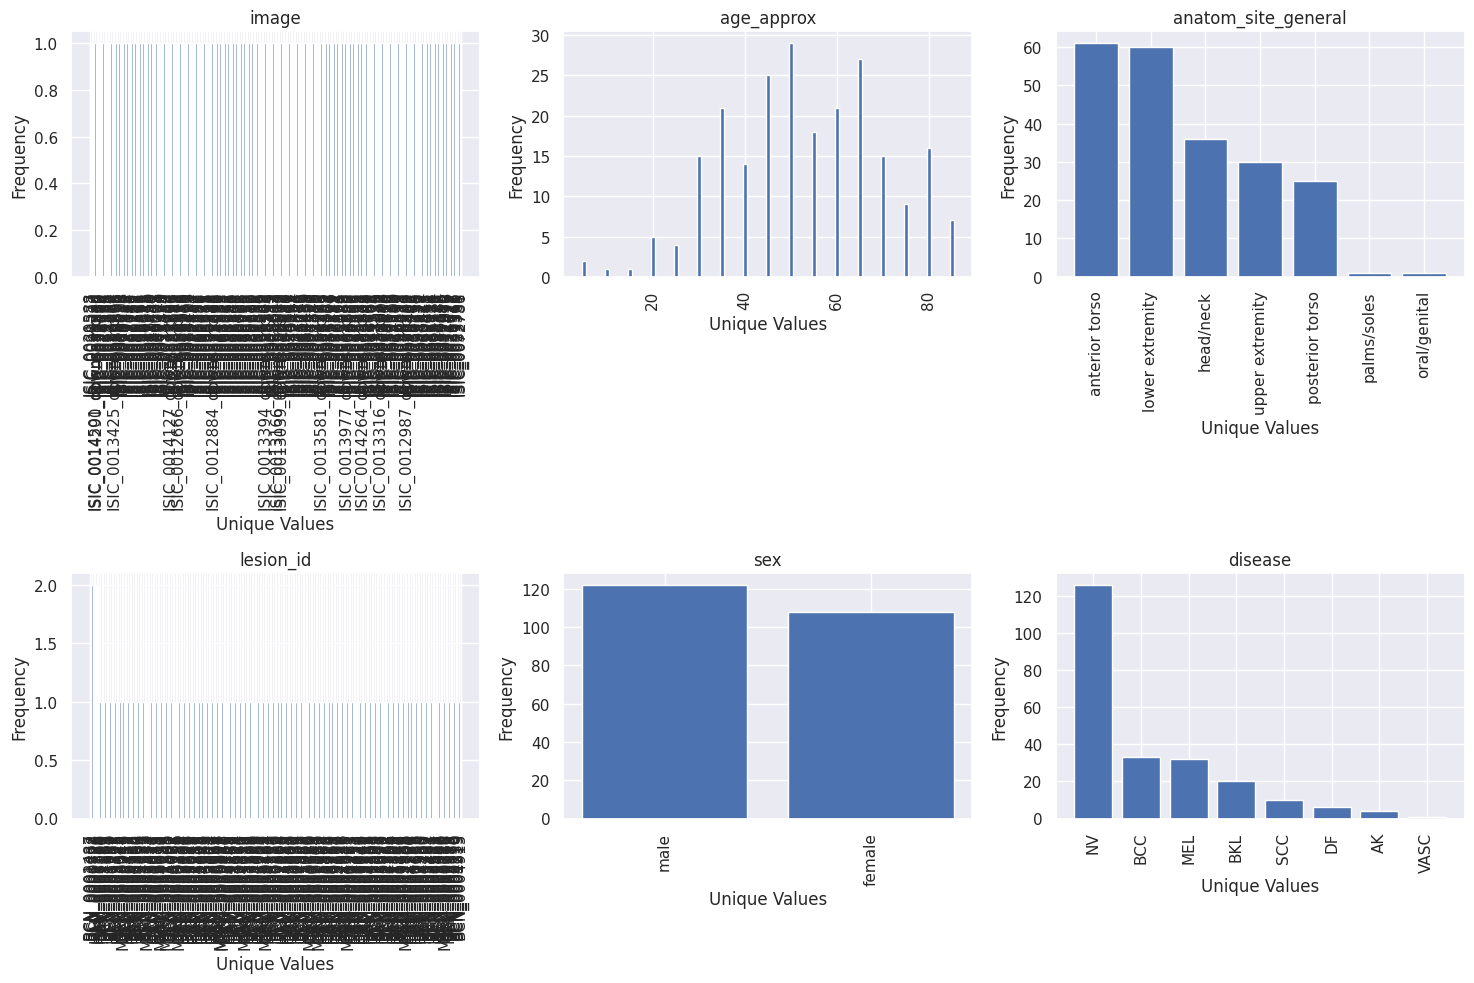

In [ ]:
df = nonull_df.sample(frac=0.01, random_state=42)

cols = df.columns
n_cols = len(cols)

n_columns = 3
n_rows = (n_cols + n_columns - 1) // n_columns
fig, axes = plt.subplots(n_rows, n_columns, figsize=(15, 5 * n_rows))

axes = axes.flatten()
for i, column in enumerate(cols):
    value_counts = df[column].value_counts()
    axes[i].bar(value_counts.index, value_counts.values)
    axes[i].set_title(column)
    axes[i].set_xlabel('Unique Values')
    axes[i].set_ylabel('Frequency')
    axes[i].tick_params(axis='x', rotation=90)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Note: there is a high frequency of data of the label NV related to other diseases --> account for data sparsity effect through the model

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import Image
from matplotlib.pyplot import imread
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "GPU Running" if tf.config.list_physical_devices("GPU") else "not available :(")

TF Hub version: 0.16.1
GPU GPU Running


In [ ]:
labels_df = nonull_df[['image', 'disease']]

In [ ]:
labels_df

,image,disease
1482,ISIC_0012678_downsampled,MEL
1497,ISIC_0012701_downsampled,MEL
1507,ISIC_0012715_downsampled,MEL
1522,ISIC_0012749_downsampled,MEL
1523,ISIC_0012756_downsampled,MEL
...,...,...
202498,ISIC_0073022,SCC
202503,ISIC_0073030,SCC
202541,ISIC_0073088,SCC
202606,ISIC_0073195,SCC


<Axes: xlabel='disease'>

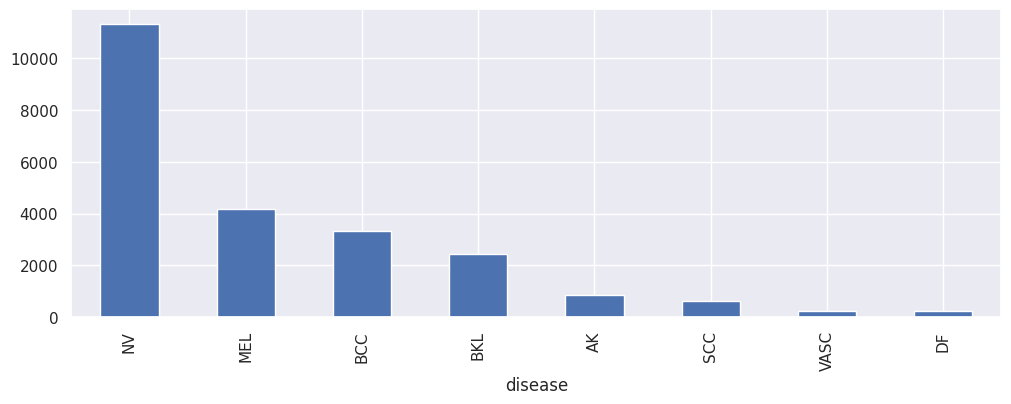

In [ ]:
labels_df["disease"].value_counts().plot.bar(figsize=(12, 4))

In [ ]:
filenames = ["drive/My Drive/ISIC_2019_Training_Input/" + fname + ".jpg" for fname in labels_df["image"]]

filenames[:5]

['drive/My Drive/ISIC_2019_Training_Input/ISIC_0012678_downsampled.jpg',
 'drive/My Drive/ISIC_2019_Training_Input/ISIC_0012701_downsampled.jpg',
 'drive/My Drive/ISIC_2019_Training_Input/ISIC_0012715_downsampled.jpg',
 'drive/My Drive/ISIC_2019_Training_Input/ISIC_0012749_downsampled.jpg',
 'drive/My Drive/ISIC_2019_Training_Input/ISIC_0012756_downsampled.jpg']

In [ ]:
labels = labels_df["disease"].to_numpy()

In [ ]:
unique_types = np.unique(labels)
len(unique_types)
unique_types

array(['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC'], dtype=object)

In [ ]:
#structure data so that there is one "true" value associated with one of the headers (unique types)
boolean_labels = [label == unique_types for label in labels]
boolean_labels[:2]

[array([False, False, False, False,  True, False, False, False]),
 array([False, False, False, False,  True, False, False, False])]

##Image preprocessing
### As images cannot be directly inputted into a CNN, we turn the images into preprocessed tensors to assist

In [ ]:
IMG_WIDTH = 224 #224
IMG_HEIGHT = 224 #224

#Turns images into tensors
def process_image(image_path, img_width=IMG_WIDTH, img_height=IMG_HEIGHT):
  image = tf.io.read_file(image_path)
  #turns image into tensor with RGB (3 color channels)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_WIDTH, IMG_HEIGHT])

  print(image.shape)
  return image

In [ ]:
def get_image_label(image_path, label):
  image = process_image(image_path)
  return image, label

In [ ]:
BATCH_SIZE = 64

def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  #No labels
  if test_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  #Labels without shuffling
  elif valid_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  #Labels with shuffling
  else:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data = data.map(get_image_label)
    data_batch = data.batch(BATCH_SIZE)


  return data_batch

In [ ]:
X = filenames
y = boolean_labels
print(f"# of files is {len(X)}")

# of files is 23247


In [ ]:
IMAGE_TRAIN_SPLIT = 0.7
IMAGE_TEST_SPLIT = 0.1

#Split into train, validation, and test dats according to this split: 0.7, 0.2, 0.1
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=1-IMAGE_TRAIN_SPLIT, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=IMAGE_TEST_SPLIT/(1-IMAGE_TRAIN_SPLIT), random_state=42)

In [ ]:
#make into tensors
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

(224, 224, 3)
(224, 224, 3)


## Training
### Below, we experiment with different approached to building a CNN for this problem

In [ ]:
#constants
INPUT_SHAPE = [None, IMG_WIDTH, IMG_HEIGHT, 3] # batch, height, width, colour channels
INPUT_SHAPE_NO_BATCH = [IMG_WIDTH, IMG_WIDTH, 3] # height, width, colour channels
OUTPUT_SHAPE = len(unique_types)
MOBILE_NET_URL = "https://kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/130-224-classification/versions/1"
EFFICIENT_NET_URL = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-classification/versions/2"

In [ ]:
# This model is built opon the mobile net model
def create_model_mobile_net(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MOBILE_NET_URL):
  model = tf.keras.Sequential([
    hub.KerasLayer(model_url),
    tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                          activation="softmax")
  ])

  model.compile(
      loss='binary_crossentropy',
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'] #'rmse', 'roc_auc'
  )

  model.build(INPUT_SHAPE)

  return model

In [ ]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Sequential
from tensorflow.keras import Model
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D,Activation, BatchNormalization

# This model is built around the efficient net model w/ a rebuilt top layer
def create_model_efficientnet1(input_shape=INPUT_SHAPE_NO_BATCH, output_shape=OUTPUT_SHAPE):
  model = tf.keras.applications.efficientnet.EfficientNetB4(weights='imagenet',include_top=False, input_shape=input_shape)
  model.trainable = False

  # Rebuild top
  conv = MaxPooling2D(pool_size=(2, 2),padding="same")(model.output)
  conv = (BatchNormalization()(conv))

  conv= Activation("relu")(conv)
  conv= Dropout(0.5)(conv)

  conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
  conv=(BatchNormalization()(conv))
  conv=(Conv2D(filters=512,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
  conv=(BatchNormalization()(conv))
  conv=(Conv2D(filters=512,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv))
  conv=(BatchNormalization()(conv))

  conv=(MaxPooling2D(pool_size=(4, 4),padding="same")(conv))

  conv=(Flatten()(conv))
  conv=(Dense(4096,activation="relu")(conv))
  conv=(Dense(4096,activation="relu")(conv))
  conv=(Dense(8, activation="softmax")(conv)) #should be 7??

  model = Model(inputs=input_shape, outputs=conv,name="EfficientNetB4")

  model.compile(
      loss='binary_crossentropy',
      optimizer=tf.keras.optimizers.Adam(),
      metrics=['accuracy'] #TODO: 'rmse', 'roc_auc'
  )

  model.build(INPUT_SHAPE)
  return model

#This model is built around the efficient net model without a rebuilt top layer
def create_model_efficientnet2(input_shape=INPUT_SHAPE_NO_BATCH, output_shape=OUTPUT_SHAPE):
  #Using EfficientNetB4
  base_model = tf.keras.applications.EfficientNetB4(include_top=False, input_shape=input_shape)

  # model = models.Sequential()
  model = models.Sequential()
  model.add(base_model)
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

  model.add(layers.Flatten())
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(output_shape))

  model.compile(optimizer='adam',
            loss=tf.keras.losses.CategoricalCrossentropy(),
            # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
  model.build(input_shape)

  return model;


In [ ]:
# Custom built CNN model
def create_model_cnn(input_shape=INPUT_SHAPE_NO_BATCH, output_shape=OUTPUT_SHAPE):
  model = Sequential()

  model.add(layers.Conv2D(32, (3,3), input_shape = input_shape, activation = 'relu'))
  model.add(layers.MaxPooling2D(2,2))

  model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
  model.add(layers.MaxPooling2D(2,2))

  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
  model.add(layers.MaxPooling2D(2,2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Conv2D(256, (3,3), activation = 'relu'))
  model.add(layers.MaxPooling2D(2,2))

  model.add(layers.Flatten())
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(output_shape, activation='sigmoid'))

  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer=tf.keras.optimizers.Adam(lr=0.001),
      metrics=['accuracy'] #TODO: 'rmse', 'roc_auc'
  )

  return model;

In [ ]:
model = create_model_cnn()

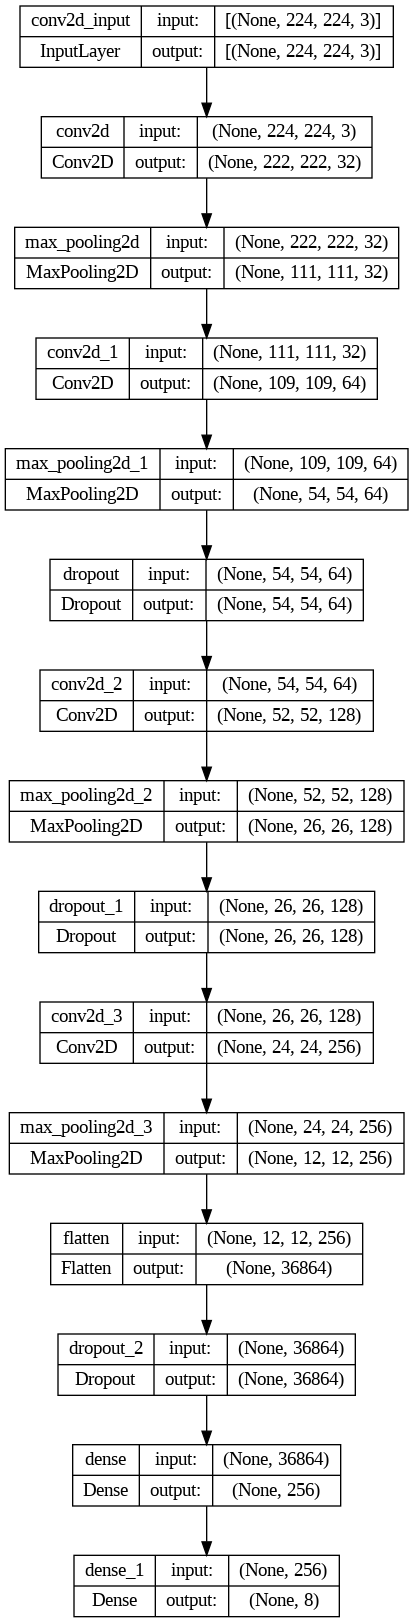

In [ ]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
%load_ext tensorboard
import datetime

def create_tensorboard_callback():
  logdir = os.path.join("drive/My Drive/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, monitor="val_accuracy",
                                                  patience=5, verbose=1)
early_stopping_loss = tf.keras.callbacks.EarlyStopping(restore_best_weights=True, monitor="val_loss",
                                                  patience=5, verbose=1)

In [ ]:
def tuner():
  tuner = tf.keras.Hyperband(model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='tuner',
                     project_name='skin_detection')
  tuner.search(train_data, epochs=50, validation_split=0.2, callbacks=[early_stopping_loss])

  best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

  print(f"""# of number of units in the first densely-connected
  layer is {best_hps.get('units')} and the  learning rate
  is {best_hps.get('learning_rate')}.
  """)
  new_model = tuner.hypermodel.build(best_hps)
  return new_model

In [ ]:
def create_checkpoint_callback(modelName="ckpt"):
   checkpoint_filepath = os.path.dirname('/tmp/' + modelName + '/checkpoint.weights.h5')
   return tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [ ]:
NUM_EPOCHS = 10 #experimental value

def train_model(model, epoch=NUM_EPOCHS):
  """
  Trains a given model and returns the trained version.
  """

  tensorboard = create_tensorboard_callback()
  model_checkpoint_callback = create_checkpoint_callback();
  # history plots to dict of different metrics at different epochs
  return model.fit(x=train_data,
            epochs=epoch,
            validation_data=val_data,
            callbacks=[tensorboard, early_stopping],
            verbose=1)

In [ ]:
history = train_model(model)

Epoch 1/10
255/255 [==============================] - 2573s 10s/step - loss: 0.2501 - accuracy: 0.5745 - val_loss: 0.2155 - val_accuracy: 0.6284
Epoch 2/10
255/255 [==============================] - 226s 888ms/step - loss: 0.2161 - accuracy: 0.6222 - val_loss: 0.2100 - val_accuracy: 0.6383
Epoch 3/10
255/255 [==============================] - 209s 818ms/step - loss: 0.2099 - accuracy: 0.6324 - val_loss: 0.2071 - val_accuracy: 0.6516
Epoch 4/10
255/255 [==============================] - 209s 821ms/step - loss: 0.2064 - accuracy: 0.6375 - val_loss: 0.2091 - val_accuracy: 0.6314
Epoch 5/10
255/255 [==============================] - 211s 825ms/step - loss: 0.2038 - accuracy: 0.6464 - val_loss: 0.2022 - val_accuracy: 0.6508
Epoch 6/10
255/255 [==============================] - 225s 884ms/step - loss: 0.2024 - accuracy: 0.6428 - val_loss: 0.2032 - val_accuracy: 0.6555
Epoch 7/10
255/255 [==============================] - 209s 818ms/step - loss: 0.1989 - accuracy: 0.6508 - val_loss: 0.2035 - 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 54, 54, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       7

In [ ]:
%tensorboard --logdir drive/My Drive/logs

In [ ]:
def save_model(model, ending="", extension=".keras"):
  modeldir = os.path.join("drive/My Drive/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + ending + extension
  model.save(model_path)
  return model_path

In [ ]:
def load_model(filename, folder = "drive/My Drive/models/", typee=".keras"):
  new_model = tf.keras.models.load_model(folder + filename + typee)
  return new_model

In [ ]:
model = load_model("20240103-07001704265250-third-attempt-all")

In [ ]:
save_model(model, ending="custom-cnn")
# model = load_model("drive/My Drive/models/20231128-03061701140802-first-attempt-100", typee=="") #RUN THIS OR THE ABOVE COMMENTED LINE


'drive/My Drive/models/20240613-18221718302950-custom-cnn.keras'

In [ ]:
def most_likely(probs):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_types[np.argmax(probs)]
def unbatchify(data):
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(most_likely(label))
  return images, labels

In [ ]:
predictions = model.predict(val_data)
val_images, val_labels = unbatchify(val_data)

In [ ]:
def plot_pred_conf(ax, pred_prob, true_label):
  top_3_pred_indexes = pred_prob.argsort()[-8:][::-1]
  top_3_pred_values = pred_prob[top_3_pred_indexes]
  top_3_pred_labels = unique_types[top_3_pred_indexes]

  top_plot = ax.bar(np.arange(len(top_3_pred_labels)),
                     top_3_pred_values,
                     color="grey") #Todo add title
  ax.set_xticks(np.arange(len(top_3_pred_labels)),
             labels=top_3_pred_labels,
             rotation="vertical")
  if np.isin(true_label, top_3_pred_labels):
    top_plot[np.argmax(top_3_pred_labels == true_label)].set_color("green")
  else:
    pass

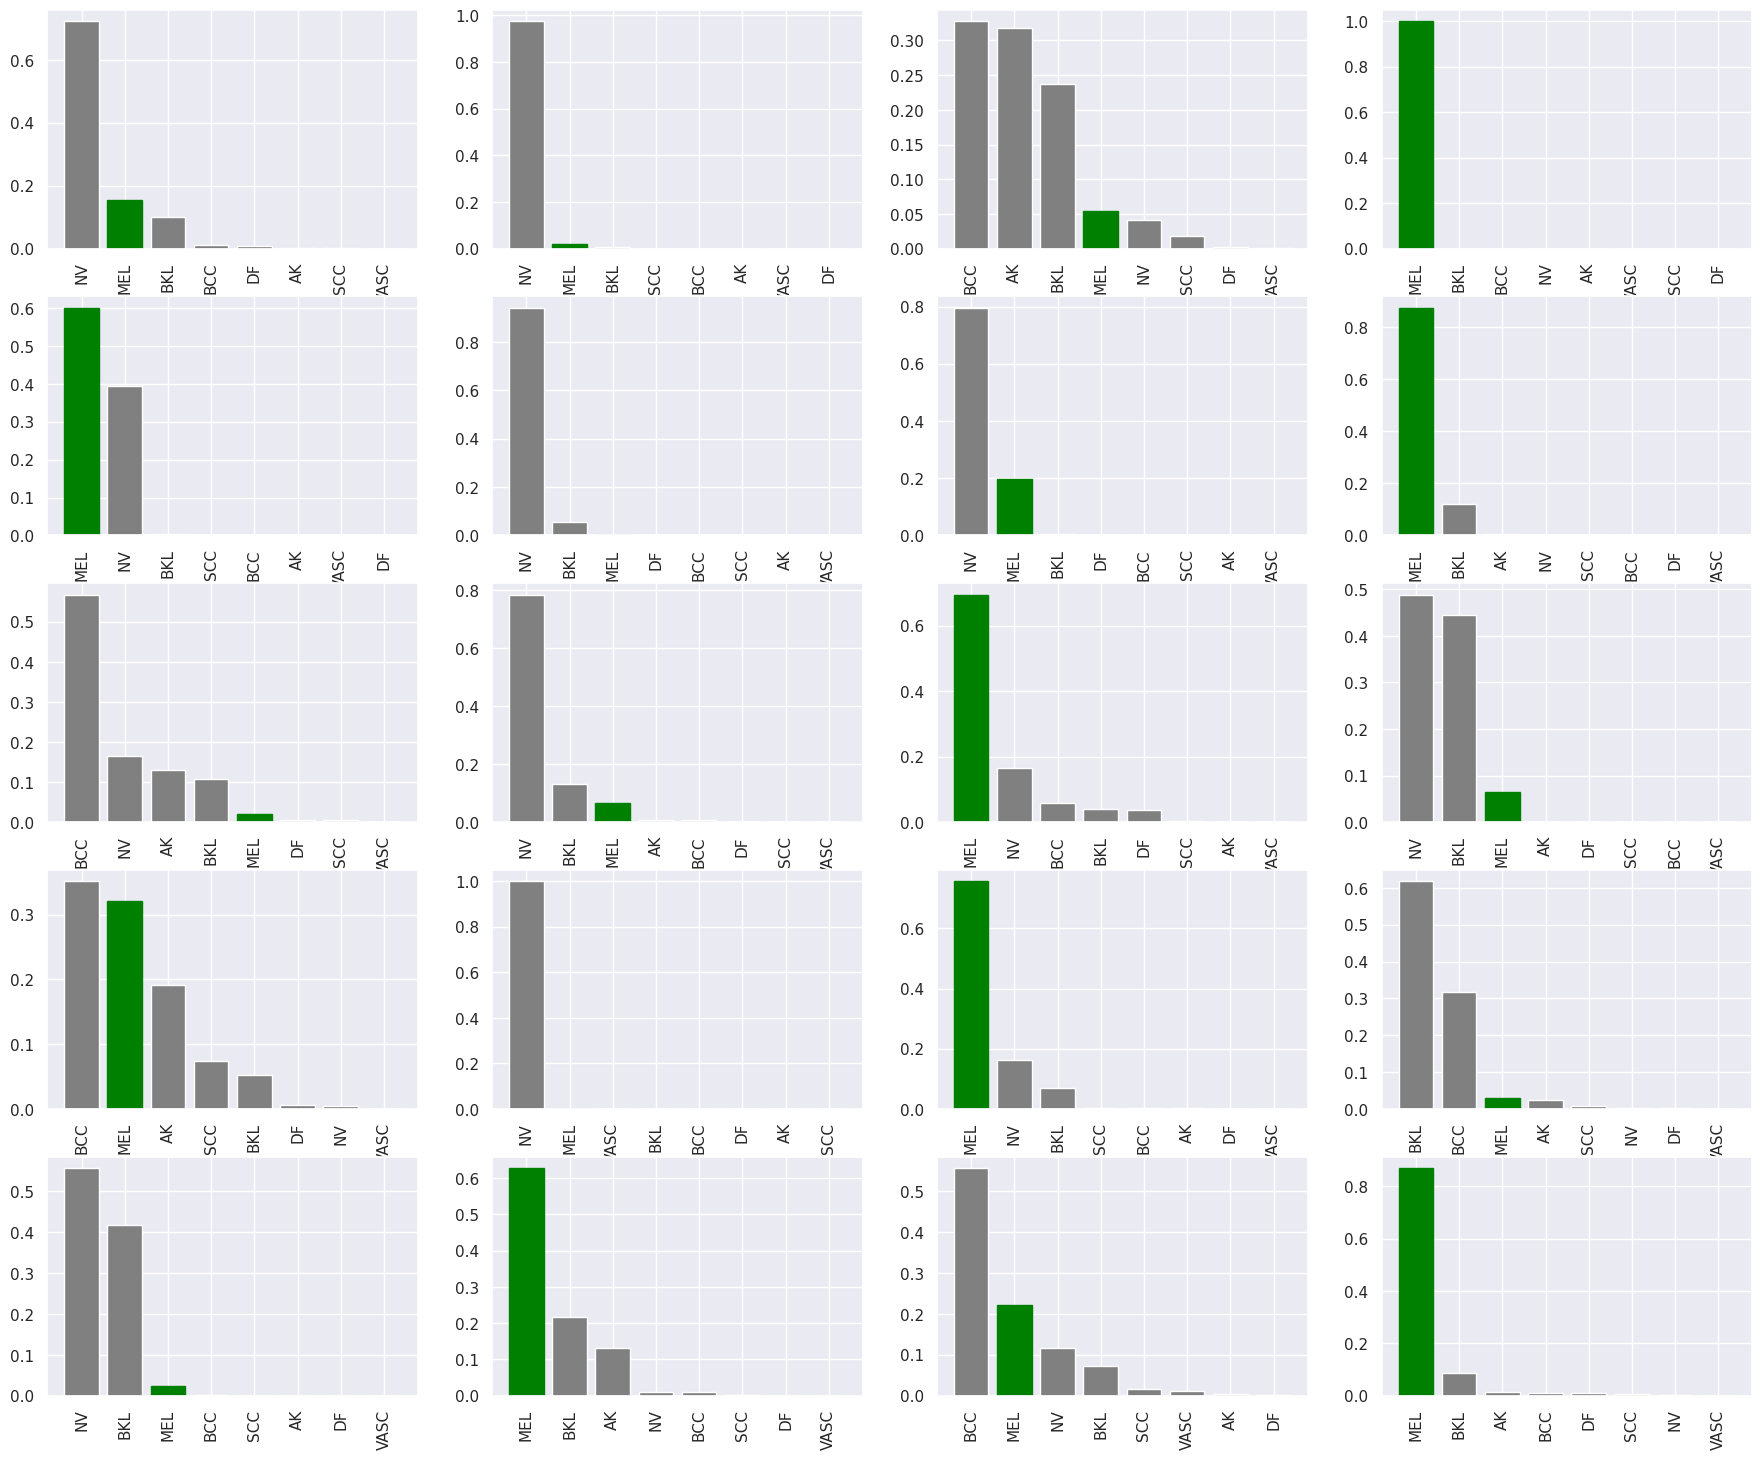

In [ ]:
fig, axs = plt.subplots(5, 4, figsize=(22, 18))
axs = axs.flatten()

j = 0;
for i in range(1000,1020):
  plot_pred_conf(axs[j], predictions[i],
                labels[i])
  j+=1

In [ ]:
model.evaluate(val_data)

37/37 [==============================] - 22s 583ms/step - loss: 0.1967 - accuracy: 0.6671


[0.19674833118915558, 0.6670967936515808]

In [ ]:
model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.19674833>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.6670968>}

In [ ]:
prediction_labels = []

for i in predictions:
  prediction_labels.append(most_likely(i))

In [ ]:
class_report = classification_report(val_labels, prediction_labels)

In [ ]:
print(class_report)

              precision    recall  f1-score   support

          AK       0.24      0.12      0.16        76
         BCC       0.55      0.75      0.63       335
         BKL       0.38      0.50      0.43       229
          DF       0.29      0.08      0.12        26
         MEL       0.61      0.52      0.56       426
          NV       0.82      0.83      0.82      1137
         SCC       0.56      0.07      0.13        70
        VASC       0.92      0.42      0.58        26

    accuracy                           0.67      2325
   macro avg       0.55      0.41      0.43      2325
weighted avg       0.67      0.67      0.66      2325



In [ ]:
c_mat = metrics.confusion_matrix(val_labels, prediction_labels)
sns.heatmap(c_mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('True');
plt.ylabel('Predicted');